# **Clasificatiemodellen in machine learning**

**imports & connection**

In [26]:
import pandas as pd
import pyodbc
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


In [27]:
DB = {'servername': 'LAPTOP-LPE28RPE\SQLEXPRESS', 
    'database': 'United_outdoors'}

export_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + 
                              ';DATABASE=' + DB['database'])

export_cursor = export_conn.cursor()
export_cursor   

**Database connection**

In [28]:
Adventure = {
    'servername' : 'LAPTOP-LPE28RPE\SQLEXPRESS',
    'database' : 'AdventureWorks2019'
}


Northwind = {
    'servername' : 'LAPTOP-LPE28RPE\SQLEXPRESS',
    'database' : 'Northwind'
}

access_db_path = r'C:\Users\Humberto de Castro\OneDrive\Desktop\SEM4\AenC\aenc.accdb'

#Connect to AdventureWorks
Adventure_conn = pyodbc.connect(f"DRIVER={{SQL Server}};SERVER={Adventure['servername']};DATABASE={Adventure['database']};Trusted_Connection=yes;")
Adventure_cursor = Adventure_conn.cursor()

#Connect to Northwind
Northwind_conn = pyodbc.connect(f"DRIVER={{SQL Server}};SERVER={Northwind['servername']};DATABASE={Northwind['database']};Trusted_Connection=yes;")
Northwind_cursor = Northwind_conn.cursor()

#Connect to AenC
AenC_conn = pyodbc.connect(f"DRIVER={{Microsoft Access Driver (*.mdb, *.accdb)}};DBQ={access_db_path};")



In [29]:
AdventureWorks_queries = {
    'Shipmethod' : 'SELECT * FROM Purchasing.Shipmethod',
    'SalesOrderHeader' : 'SELECT * FROM Sales.SalesOrderHeader',
    'SalesOrderDetail' : 'SELECT * FROM Sales.SalesOrderDetail'
}

Northwind_queries = {
    'Shippers' : 'SELECT * FROM Shippers',
    'Orders' : 'SELECT * FROM Orders',
    'OrderDetails' : 'SELECT * FROM [Order Details]'
}


AenC_queries = {
    'sales_order' : 'SELECT * FROM sales_order',
    'sales_order_item' : 'SELECT * FROM sales_order_item',
    'Product' : 'SELECT * FROM Product',
    'sales_order' : 'SELECT * FROM sales_order',
    'sales_order_item' : 'SELECT * FROM sales_order_item',
    'Product' : 'SELECT * FROM Product' 
}

dataframes = {}

# Lees elke tabel in een DataFrame

for table_name, query in AdventureWorks_queries.items():
    dataframes[table_name] = pd.read_sql_query(query, Adventure_conn)

for table_name, query in Northwind_queries.items():
    dataframes[table_name] = pd.read_sql_query(query, Northwind_conn)

for table_name, query in AenC_queries.items():
    dataframes[table_name] = pd.read_sql_query(query, AenC_conn)

#als je ik elk tabel als een dataframe/ variabele wil behandelen of aanroepen moet ik dit uitvoeren.
for table_name, df in dataframes.items():
    globals()[table_name] = df


C:\Users\Humberto de Castro\AppData\Local\Temp\ipykernel_24268\3447240921.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataframes[table_name] = pd.read_sql_query(query, Adventure_conn)
C:\Users\Humberto de Castro\AppData\Local\Temp\ipykernel_24268\3447240921.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataframes[table_name] = pd.read_sql_query(query, Northwind_conn)
C:\Users\Humberto de Castro\AppData\Local\Temp\ipykernel_24268\3447240921.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataframes[table

## Ship/Order

Transform

In [30]:
Shippers.rename(columns={
    'ShipperID': 'ShipMethodID',
    'CompanyName' : 'Name'
}, inplace=True)

In [31]:
Shipmethod['ShipMethodID'] = Shipmethod['ShipMethodID'].apply(lambda x: f'AW_{x}')
Shippers['ShipMethodID'] = Shippers['ShipMethodID'].apply(lambda x: f'NW_{x}')
# AenC_Order heeft geen ShipMethodID

In [32]:
# Zorg ervoor dat alle vereiste kolommen bestaan en selecteer ze
required_columns = ['ShipMethodID', 'Name', 'ShipBase', 'ShipRate']

for col in required_columns:
    if col not in Shippers.columns:
        Shippers[col] = None
    if col not in Shipmethod.columns:
        Shipmethod[col] = None

# Selecteer de kolommen in de juiste volgorde
Shippers = Shippers[required_columns]
Shipmethod = Shipmethod[required_columns]

# Combineer de dataframes
Ship = pd.concat([Shipmethod, Shippers], ignore_index=True)

print(Ship.dtypes)

ShipMethodID     object
Name             object
ShipBase        float64
ShipRate        float64
dtype: object


C:\Users\Humberto de Castro\AppData\Local\Temp\ipykernel_24268\3011861440.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Ship = pd.concat([Shipmethod, Shippers], ignore_index=True)


### Order

In [33]:
#eerst horizontaal samenvoegen per database:
AdventureWorks_Order = pd.merge(SalesOrderHeader, SalesOrderDetail, on = 'SalesOrderID')
Northwind_Order = pd.merge(Orders, OrderDetails, on = 'OrderID')
merge1 = pd.merge(Product, sales_order_item, left_on= 'id', right_on= 'prod_id')
AenC_Order = pd.merge(merge1, sales_order, left_on = 'id_y', right_on = 'id')

Transform

In [34]:
AdventureWorks_Order.rename(columns={
    'SalesOrderID': 'OrderID',
    'SalesOrderDetailID': 'OrderDetailID',
    'OrderQty': 'Quantity',
    'UnitPriceDiscount': 'Discount',
    'Order_Date': 'OrderDate',
    'SalesPersonID' : 'EmployeeID'
}, inplace=True)

# Vul NaN waarden in EmployeeID met een standaardwaarde (bijv. 0)
AdventureWorks_Order['EmployeeID'].fillna(0, inplace=True)

# change employe id type to int

AdventureWorks_Order['EmployeeID'] = AdventureWorks_Order['EmployeeID'].astype(int)

# change shipvia to string 
#Northwind_Order['ShipVia'] = Northwind_Order['ShipVia'].astype(str)
Northwind_Order.rename(columns={
    'ShipVia': 'ShipMethodID'
}, inplace=True)

AenC_Order.rename(columns={
    'id': 'OrderID',
    'item_id': 'OrderDetailID',
    'quantity_y': 'Quantity',
    'order_date': 'OrderDate',
    'unit_price': 'UnitPrice',
    'cust_id': 'CustomerID',
    'sales_rep': 'EmployeeID',
    'prod_id': 'ProductID'
}, inplace=True)

C:\Users\Humberto de Castro\AppData\Local\Temp\ipykernel_24268\2543201151.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  AdventureWorks_Order['EmployeeID'].fillna(0, inplace=True)


In [35]:
# Prefixes toevoegen
AdventureWorks_Order['EmployeeID'] = AdventureWorks_Order['EmployeeID'].apply(lambda x: f'AW_{x}')
Northwind_Order['EmployeeID'] = Northwind_Order['EmployeeID'].apply(lambda x: f'NW_{x}')
AenC_Order['EmployeeID'] = AenC_Order['EmployeeID'].apply(lambda x: f'AC_{x}')

# Vervang 'AW_0' met 'NULL' in de kolom EmployeeID
AdventureWorks_Order['EmployeeID'] = AdventureWorks_Order['EmployeeID'].replace('AW_0', None)

AdventureWorks_Order['ShipMethodID'] = AdventureWorks_Order['ShipMethodID'].apply(lambda x: f'AW_{x}')
Northwind_Order['ShipMethodID'] = Northwind_Order['ShipMethodID'].apply(lambda x: f'NW_{x}')
# AenC_Order heeft geen ShipMethodID

AdventureWorks_Order['ProductID'] = AdventureWorks_Order['ProductID'].apply(lambda x: f'AW_{x}')
Northwind_Order['ProductID'] = Northwind_Order['ProductID'].apply(lambda x: f'NW_{x}')
AenC_Order['ProductID'] = AenC_Order['ProductID'].apply(lambda x: f'AC_{x}')

AdventureWorks_Order['CustomerID'] = AdventureWorks_Order['CustomerID'].apply(lambda x: f'AW_{x}')
Northwind_Order['CustomerID'] = Northwind_Order['CustomerID'].apply(lambda x: f'NW_{x}')
AenC_Order['CustomerID'] = AenC_Order['CustomerID'].apply(lambda x: f'AC_{x}')

In [36]:
# Zorg ervoor dat alle vereiste kolommen bestaan en selecteer ze
required_columns = ['OrderID', 'OrderDetailID', 'Quantity', 'UnitPrice', 'Discount', 'OrderDate', 'CustomerID', 'EmployeeID', 'ShipMethodID', 'ProductID']

for col in required_columns:
    if col not in AdventureWorks_Order.columns:
        AdventureWorks_Order[col] = None
    if col not in Northwind_Order.columns:
        Northwind_Order[col] = None
    if col not in AenC_Order.columns:
        AenC_Order[col] = None

# Selecteer de kolommen in de juiste volgorde
AdventureWorks_Order = AdventureWorks_Order[required_columns]
Northwind_Order = Northwind_Order[required_columns]
AenC_Order = AenC_Order[required_columns]

# Combineer de dataframes
Order = pd.concat([AdventureWorks_Order, Northwind_Order, AenC_Order], ignore_index=True)

Order['ShipMethodID'] = Order['ShipMethodID'].fillna('0')  # Vervang None waarden met 0

# Converteer 'Quantity' en 'UnitPrice' naar numerieke typen
Order['Quantity'] = pd.to_numeric(Order['Quantity'], errors='coerce')
Order['UnitPrice'] = pd.to_numeric(Order['UnitPrice'], errors='coerce')

Order['Omzet'] = Order['UnitPrice'] * Order['Quantity']

# Toon het resultaat
#print(combined_df)
print(Order.dtypes)

C:\Users\Humberto de Castro\AppData\Local\Temp\ipykernel_24268\1429481879.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Order = pd.concat([AdventureWorks_Order, Northwind_Order, AenC_Order], ignore_index=True)


OrderID           object
OrderDetailID     object
Quantity           int64
UnitPrice        float64
Discount         float64
OrderDate         object
CustomerID        object
EmployeeID        object
ShipMethodID      object
ProductID         object
Omzet            float64
dtype: object


## **One-hot encoding van onafhankelijke kolommen niet-numerieke variabelen**

In [37]:
Ship = Ship.loc[:, ['Name', 'ShipBase', 'ShipRate']]

Order = Order.loc[:, ['Quantity', 'UnitPrice', 'Omzet', 'ShipMethodID']]

## **horizontaal en Verticaal snijden**

In [38]:
x = Order.drop('ShipMethodID', axis=1)
y = Order.loc[:, 'ShipMethodID']

x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size = 0.15,
    random_state = 42
)
x_train

#rder.columns = Order.columns.astype(str)

,Quantity,UnitPrice,Omzet
35045,3,1242.8518,3728.5554
71554,1,34.9900,34.9900
3374,16,26.4370,422.9920
39152,1,1214.8500,1214.8500
66284,1,2.2900,2.2900
...,...,...,...
119879,1,2.2900,2.2900
103694,8,1430.4420,11443.5360
860,3,419.4589,1258.3767
15795,1,2181.5625,2181.5625


## **Decision Tree bouwen en evalueren**

## **Max_depth = 2**

**Training model**

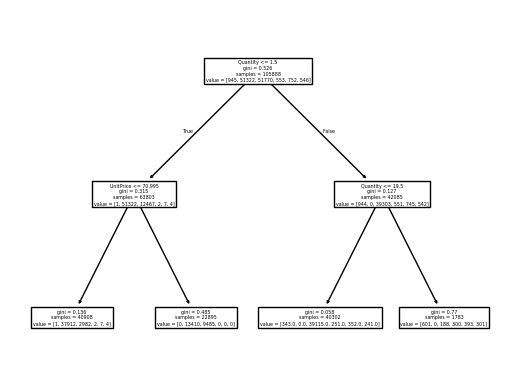

In [39]:
dtree = DecisionTreeClassifier(max_depth=2)
dtree = dtree.fit(x_train, y_train)
tree.plot_tree(dtree, feature_names= x.columns)

plt.show()

**Prediction met x_test**

In [40]:
predicted_df = pd.DataFrame(dtree.predict(x_test))
predicted_df = predicted_df.rename(columns = {0: 'Predicted Shipmethod'})
predicted_df

,Predicted Shipmethod
0,AW_1
1,AW_1
2,AW_1
3,AW_5
4,AW_1
...,...
18682,AW_1
18683,AW_1
18684,AW_1
18685,AW_5


**Prediction vergelijken met y_test**

In [41]:
model_results_frame = pd.concat([y_test.reset_index()['ShipMethodID'], predicted_df],  axis=1)
model_results_frame

,ShipMethodID,Predicted Shipmethod
0,AW_1,AW_1
1,AW_1,AW_1
2,AW_1,AW_1
3,AW_5,AW_5
4,AW_1,AW_1
...,...,...
18682,AW_1,AW_1
18683,AW_1,AW_1
18684,AW_1,AW_1
18685,AW_5,AW_5


**Confusion matrix**

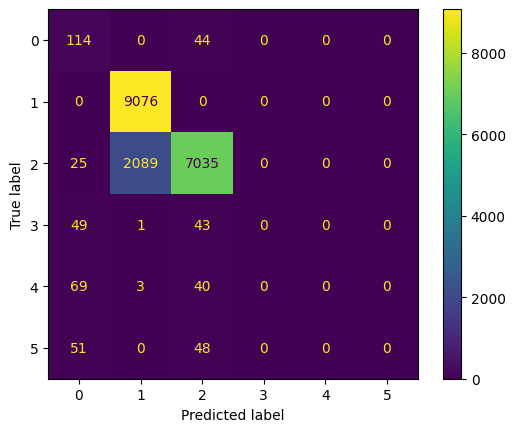

In [42]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['ShipMethodID'], model_results_frame['Predicted Shipmethod'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
#display_labels= ["Def", "Incomp", "Worder", "Wship", "Unsatis"]
cm_display.plot()
plt.show()

**Accuracy score**

In [43]:
metrics.accuracy_score(model_results_frame['ShipMethodID'], model_results_frame['Predicted Shipmethod'])

0.8682506555359341

**Classification report**

In [44]:
print(classification_report(y_test, predicted_df))

c:\Users\Humberto de Castro\AppData\Local\pypoetry\Cache\virtualenvs\uo-bedrijf-V1uT7Q__-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.37      0.72      0.49       158
        AW_1       0.81      1.00      0.90      9076
        AW_5       0.98      0.77      0.86      9149
        NW_1       0.00      0.00      0.00        93
        NW_2       0.00      0.00      0.00       112
        NW_3       0.00      0.00      0.00        99

    accuracy                           0.87     18687
   macro avg       0.36      0.42      0.37     18687
weighted avg       0.88      0.87      0.86     18687



c:\Users\Humberto de Castro\AppData\Local\pypoetry\Cache\virtualenvs\uo-bedrijf-V1uT7Q__-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Humberto de Castro\AppData\Local\pypoetry\Cache\virtualenvs\uo-bedrijf-V1uT7Q__-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **Max_depth = 3**

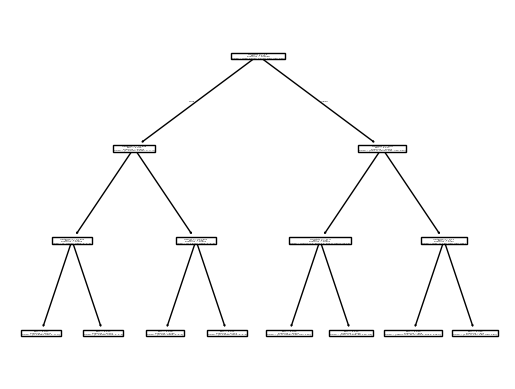

In [45]:
dtree = DecisionTreeClassifier(max_depth=3) 
dtree = dtree.fit(x_train, y_train)
tree.plot_tree(dtree, feature_names= x.columns)
plt.show()

**Prediction met x_test**

In [46]:
predicted_df = pd.DataFrame(dtree.predict(x_test))
predicted_df = predicted_df.rename(columns = {0: 'Predicted Shipmethod'})
predicted_df

,Predicted Shipmethod
0,AW_1
1,AW_1
2,AW_1
3,AW_5
4,AW_1
...,...
18682,AW_1
18683,AW_1
18684,AW_1
18685,AW_5


**Prediction vergelijken met y_test**

In [47]:
model_results_frame = pd.concat([y_test.reset_index()['ShipMethodID'], predicted_df],  axis=1)
model_results_frame


,ShipMethodID,Predicted Shipmethod
0,AW_1,AW_1
1,AW_1,AW_1
2,AW_1,AW_1
3,AW_5,AW_5
4,AW_1,AW_1
...,...,...
18682,AW_1,AW_1
18683,AW_1,AW_1
18684,AW_1,AW_1
18685,AW_5,AW_5


**Confusion matrix**

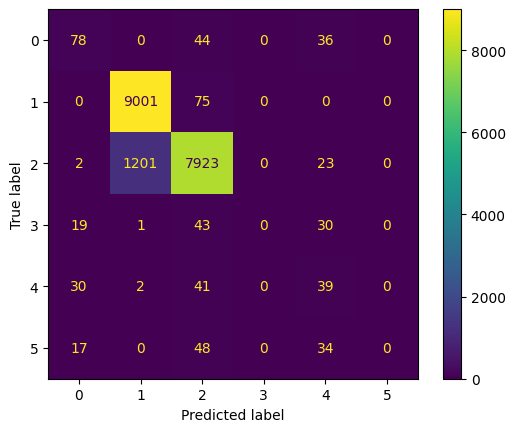

In [48]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['ShipMethodID'], model_results_frame['Predicted Shipmethod'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
#display_labels= ["Def", "Incomp", "Worder", "Wship", "Unsatis"]
cm_display.plot()
plt.show()

**Accuracy score**

In [49]:
metrics.accuracy_score(model_results_frame['ShipMethodID'], model_results_frame['Predicted Shipmethod'])

0.9119173757157382

**Classification report**

In [50]:
print(classification_report(y_test, predicted_df))

c:\Users\Humberto de Castro\AppData\Local\pypoetry\Cache\virtualenvs\uo-bedrijf-V1uT7Q__-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Humberto de Castro\AppData\Local\pypoetry\Cache\virtualenvs\uo-bedrijf-V1uT7Q__-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.53      0.49      0.51       158
        AW_1       0.88      0.99      0.93      9076
        AW_5       0.97      0.87      0.91      9149
        NW_1       0.00      0.00      0.00        93
        NW_2       0.24      0.35      0.28       112
        NW_3       0.00      0.00      0.00        99

    accuracy                           0.91     18687
   macro avg       0.44      0.45      0.44     18687
weighted avg       0.91      0.91      0.91     18687



c:\Users\Humberto de Castro\AppData\Local\pypoetry\Cache\virtualenvs\uo-bedrijf-V1uT7Q__-py3.11\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [54]:
model_results_frame.rename(columns={'Predicted Shipmethod': 'PredictedShipmethod'}, inplace=True)

# Deze loaden want niet overfitten

In [57]:
# Insert data into the PredictedShipmethods table
for index, row in model_results_frame.iterrows():
    try:
        query = """
        INSERT INTO PredictedShipmethods (ShipMethodID, PredictedShipmethod)
        VALUES (?, ?)
        """
        params = (
            str(row['ShipMethodID']) if pd.notnull(row['ShipMethodID']) else None,
            str(row['PredictedShipmethod']) if pd.notnull(row['PredictedShipmethod']) else None,
        )
        export_cursor.execute(query, params)
    except pyodbc.Error as e:
        print(f"An error occurred: {e}")
        print(query)
        print("Parameters:", params)

export_conn.commit()

## **Geen Max_depth**

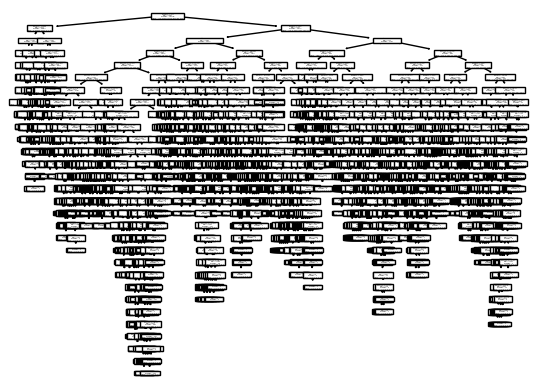

In [26]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(x_train, y_train)
tree.plot_tree(dtree, feature_names= x.columns)
plt.show()

**Evalueren**

In [27]:
predicted_df = pd.DataFrame(dtree.predict(x_test))
predicted_df = predicted_df.rename(columns = {0: 'Predicted Shipmethod'})
model_results_frame = pd.concat([y_test.reset_index()['ShipMethodID'], predicted_df],  axis=1)
model_results_frame

,ShipMethodID,Predicted Shipmethod
0,AW_1,AW_1
1,AW_1,AW_1
2,AW_1,AW_1
3,AW_5,AW_5
4,AW_1,AW_1
...,...,...
18682,AW_1,AW_1
18683,AW_1,AW_1
18684,AW_1,AW_1
18685,AW_5,AW_5


**Confusion matrix**

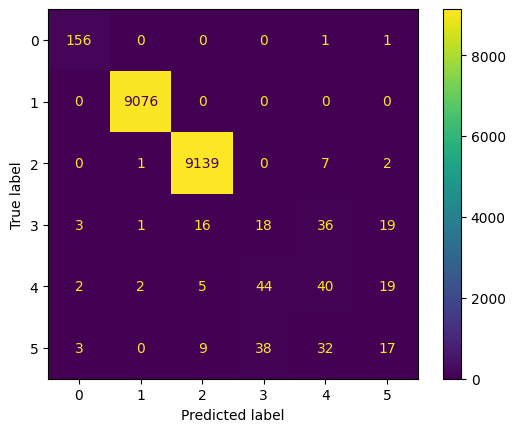

In [28]:
confusion_matrix = metrics.confusion_matrix(model_results_frame['ShipMethodID'], model_results_frame['Predicted Shipmethod'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)

cm_display.plot()
plt.show()

**Accuracy score**

In [29]:
metrics.accuracy_score(model_results_frame['ShipMethodID'], model_results_frame['Predicted Shipmethod'])

0.9871033338684647

**Classification report**

In [30]:
print(classification_report(y_test, predicted_df))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       158
        AW_1       1.00      1.00      1.00      9076
        AW_5       1.00      1.00      1.00      9149
        NW_1       0.18      0.19      0.19        93
        NW_2       0.34      0.36      0.35       112
        NW_3       0.29      0.17      0.22        99

    accuracy                           0.99     18687
   macro avg       0.63      0.62      0.62     18687
weighted avg       0.99      0.99      0.99     18687

